Hannah Weiser, 3DGeo Group, Heidelberg University

November 2021

***

# Laser scanning simulation Arboretum Heidelberg

In June 2021, the 3DGeo group and students of Heidelberg university acquired TLS point clouds of the trees in the Arboretum in Heidelberg, which includes several Sequoias. Using this data, let’s create a ULS simulation! We can compare this simulated point cloud with a real ULS point cloud acquired over the same area in August 2021.

## Objective of this HELIOS++ notebook

In this Notebook, we will cover the following topics
* Processing point cloud data for modelling HELIOS++ scenes (classification, DTM generation)
* Configuring a scene XML to load different object data types (GeoTiffs, xyz point clouds) using the `scene_writer` module of `pyhelios.utils`
* Configuring the survey XML using the `flight_planner` module of `pyhelios.utils`
* Configuring and starting a simulation using `pyhelios`
* Visualizing the simulated point cloud and trajectory using `numpy` and `matplotlib`

## Setup

We first have to make sure we have all requirements installed. Using Anaconda, please create the environment provided with the .yml file `pdal_pyhelios_env.yml` which you find in the helios root directory by typing: 

```
conda env create -f pdal_pyhelios_env.yml
```

## Imports

In [1]:
# Magic command to enable interactive plot.
%matplotlib widget
import matplotlib.pyplot as plt
import pdal
from IPython.display import display
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path, PurePath
import shutil
import time
import math
import laspy  # install with "pip install laspy[laszip]"
import urllib.request
import sys
import os
helios_path = str(Path.cwd().parent)
sys.path.append(helios_path)  # add helios-plusplus directory to PATH
import pyhelios
from pyhelios import outputToNumpy, SimulationBuilder
from pyhelios.util import flight_planner, scene_writer
from ipywidgets import Dropdown
os.chdir(helios_path)

## Input data

1) TLS point cloud

`arboretum_data/2021-06-18_TLS_Arboretum_VZ-2000i_preprocessed.laz`
This is a preprocessed point cloud of the scene, [acquired by TLS (terrestrial laser scanning) in June 2021](http://k1z.blog.uni-heidelberg.de/2021/06/21/measuring-the-tallest-sequoias-of-germany-in-student-field-campaign/). We did a simple subsampling in [CloudCompare](www.cloudcompare.org) using the "space" option and a value of 10 cm. We then extracted a rectangular subsection of the entire point cloud (bounding box: 478845.830, 5471966.184, 478983.243, 5472121.949). We filtered this point cloud by deviation, keeping only points with values below 25. Lastly, we applied a statistical outlier removal (SOR) filter with the standard deviation quantified on 6 points and a threshold *nSigma* of 1.5.

2) Real ULS point cloud

`arboretum_data/2021-08-17_ULS_Arboretum_AOI.laz`
This is a ULS (UAV-borne laser scanning) point cloud acquired over the same area in August 2021. We will use this as a reference for comparison with our simulated laser scanning data.

Let's check if the files are already existing, other wise we will download them.

In [2]:
def reporthook(count, block_size, total_size):
    percent = min(int(count * block_size * 100 / total_size), 100)
    print("\r...{}%".format(percent), end="")
        
def download_data(filename, url):
    if not Path(filename).exists():
        print("Downloading data from '{}' to '{}'. Please wait ...".format(url, filename))
        if not Path(filename).parent.exists():
            Path(filename).parent.mkdir()
        urllib.request.urlretrieve(url, filename, reporthook=reporthook)
        print("\nDownload finished")
    else:
        print("File already exists. Great!")

data_tls = "arboretum_data/2021-06-18_TLS_Arboretum_VZ-2000i_preprocessed.laz"
data_uls = "arboretum_data/2021-08-17_ULS_Arboretum_AOI.laz"
url_tls = "https://3dweb.geog.uni-heidelberg.de/helios_example_arboretum/2021-06-18_TLS_Arboretum_VZ-2000i_preprocessed.laz"
url_uls = "https://3dweb.geog.uni-heidelberg.de//helios_example_arboretum/2021-08-17_ULS_Arboretum_AOI.laz"

download_data(data_tls, url_tls)
download_data(data_uls, url_uls)

File already exists. Great!
File already exists. Great!


## The right settings for your system

A very detailed simulation might require a lot of memory and might crash or take very long depending on your available run. Therefore, choose one of the following options to configure your survey.

In [3]:
style = {'description_width': 'initial'}

def set_mode(selection):
    if selection == "light":
        voxel_size = 1.0
    elif selection == "medium":
        voxel_size = 0.25
    elif selection == "heavy": 
        voxel_size = 0.1
    
    return voxel_size

dropdown = Dropdown(
    options=['light', 'medium', 'heavy'],
    value='heavy',
    description='Which version do you want to run?',
    style=style,
    disabled=False)

voxel_size = None
def on_change(change):
    voxel_size = dropdown.value
    if change["type"] == "change" and change["name"] == "value":
        print("changed to {}".format(change["new"]))
        selection = dropdown.value
        voxel_size = set_mode(selection)
        print(f"You chose '{selection}'. Setting voxel size to {voxel_size} m.")
        
dropdown.observe(on_change)
display(dropdown)

Dropdown(description='Which version do you want to run?', index=2, options=('light', 'medium', 'heavy'), style…

In [4]:
voxel_size = set_mode(dropdown.value)

In [5]:
voxel_size

0.1

## Point cloud classification and DTM computation

Next, we compute a digital terrain model (DTM), which we will model in HELIOS++ separately from the trees. We use the [python extension](https://github.com/PDAL/python) of the open source library [PDAL](https://pdal.io/) (Point Data Abstraction Library) to create the DTM.

First, we define our output filenames.

In [6]:
data_classified = data_tls.replace("preprocessed", "classified")
dtm_output = data_tls.replace("preprocessed.laz", "dtm_50cm.tif")
vegetation_output = data_tls.replace("preprocessed.laz", "vegetation.xyz")

We start by classifying the point cloud into ground and non-ground points using the Simple Morphological Filter (SMRF) (see also [Pingel et al. 2013](https://doi.org/10.1016/j.isprsjprs.2012.12.002)).

In [7]:
json_classification = """[
    "%s",
    {
        "type":"filters.smrf",
        "ignore":"Classification[7:7]",
        "window":33,
        "slope":0.2,
        "threshold":0.5,
        "cell":1.0
    },
    {
        "type":"filters.outlier",
        "method":"statistical",
        "mean_k":8,
        "multiplier":3.0
    },
    {
        "type":"writers.las",
        "filename": "%s",
        "compression":"true"
    }
]"""

In [8]:
if not Path(data_classified).exists(): 
    pipeline = pdal.Pipeline(json_classification % (data_tls, data_classified))
    pipe_exe = pipeline.execute()

Then, we use only the ground points (class 2, according to the ASPRS Standard point classes of the [LAS format specification](http://www.asprs.org/wp-content/uploads/2019/07/LAS_1_4_r15.pdf), p. 19, Table 9) to create a DTM of 1 m resolution.

In [9]:
json_dtm = """[
    "%s",
    {
        "type":"filters.range",
        "limits":"Classification[2:2]"
    },
    {
        "type":"writers.gdal",
        "filename": "%s",
        "output_type":"min",
        "gdaldriver":"GTiff",
        "resolution":1.0,
        "window_size":8
    }
]"""

In [10]:
if not Path(dtm_output).exists():
    pipeline = pdal.Pipeline(json_dtm % (data_classified, dtm_output))
    pipe_exe = pipeline.execute()

We also want to export the non-ground points (= vegetation points) to an ASCII format. 

In [11]:
json_vegetation = """[
    "%s",
    {
        "type":"filters.range",
        "limits":"Classification[0:1]"
    },
    {
        "type":"writers.text",
        "filename": "%s",
        "order":"X,Y,Z",
        "precision":6,
        "keep_unspecified":"false",
        "write_header":"false"
    }
]"""

In [12]:
if not Path(vegetation_output).exists():
    pipeline = pdal.Pipeline(json_vegetation % (data_classified, vegetation_output))
    pipe_exe = pipeline.execute()

Now we have all the **scenepart** files needed to build a survey: The DTM and the vegetation point cloud.

## Writing the scene

To perform the scene generation and flight planning, we will use the extra tool `scene_writer.py` which comes with the `pyhelios` package.

Let's first move our **scenepart** files into a folder `arboretum_hd` in `helios\data\sceneparts`:

In [13]:
scenepart_folder = Path("data/sceneparts/arboretum_hd")
if not scenepart_folder.exists():
    Path.mkdir(scenepart_folder)

In [14]:
dtm_file = Path(scenepart_folder, PurePath(dtm_output).name)
if not dtm_file.exists():
    shutil.copy(dtm_output, dtm_file)

In [15]:
vegetation_file = Path(scenepart_folder, PurePath(vegetation_output).name)
if not vegetation_file.exists():
    shutil.copy(vegetation_output, vegetation_file)

Next, we will assemble the **scene**. In the scene-folder (`helios\data\scenes`), let’s create a new folder which we will also call `arboretum_hd`. Here, we will create a new xml-file called `arboretum_VZ-2000i.xml`. 

In [16]:
scene_folder = Path("data/scenes/arboretum_hd")
if not scene_folder.exists():
    Path.mkdir(scene_folder)

In [17]:
dtm_part = scene_writer.create_scenepart_tiff(dtm_file)
vegetation_part = scene_writer.create_scenepart_xyz(vegetation_file, sep=",", voxel_size=voxel_size)
scene_id = "arboretum"
scene_content = scene_writer.build_scene(scene_id=scene_id, name="Arboretum", sceneparts=[dtm_part, vegetation_part])

In [18]:
print(scene_content)

<?xml version="1.0" encoding="UTF-8"?>
<document>
    <scene id="arboretum" name="Arboretum">
        
        <part>
            <filter type="geotiffloader">
                <param type="string" key="filepath" value="data\sceneparts\arboretum_hd\2021-06-18_TLS_Arboretum_VZ-2000i_dtm_50cm.tif" />
                <param type="string" key="matfile" value="data/sceneparts/basic/groundplane/groundplane.mtl" />
                <param type="string" key="matname" value="None" />
            </filter>
            
        </part>

        <part>
            <filter type="xyzloader">
                <param type="string" key="filepath" value="data\sceneparts\arboretum_hd\2021-06-18_TLS_Arboretum_VZ-2000i_vegetation.xyz" />
                <param type="string" key="separator" value="," />
                <param type="double" key="voxelSize" value="0.1" />
                <!-- Normal estimation using Singular Value Decomposition (SVD)
                MODE 1: simple mode / MODE 2: advanced mode fo

The first `<part>` is the DTM, which is loaded with the `geotiffloader`.

The second `<part>` is the vegetation, for which we voxelize the vegetation point cloud with a voxel size of 0.2 m using the `xyzloader`.

For more information on the scene XML file and the different loaders, check out the [scene page in the HELIOS++ Wiki](https://github.com/3dgeo-heidelberg/helios/wiki/Scene). 

In [19]:
scene_file = scene_folder / "arboretum_VZ-2000i.xml"

In [20]:
with open(scene_file, "w") as f:
    f.write(scene_content)

## Configuring the survey

Now we have to configure the survey. We create another XML file in the `surveys` folder (`helios/data/surveys`), which we may call `arboretum_uls.xml`.

In [21]:
survey_file = "data/surveys/arboretum_uls.xml"

To perform the flight planning, we will use the `flight_planner` which comes with the `pyhelios` package.

We first define the bounding box of our area of interest.

In [22]:
bbox = [478845.830, 5471966.184, 478983.243, 5472121.949]

Next, we create a flight plan for this bounding box for a given strip spacing, and flight pattern. We furthermore rotate this pattern by 45 degrees.

In [23]:
wp, c, dist = flight_planner.compute_flight_lines(bbox, spacing=30, rotate_deg=45, flight_pattern="criss-cross")

Let's visualize our flight plan and validate that it looks as expected.

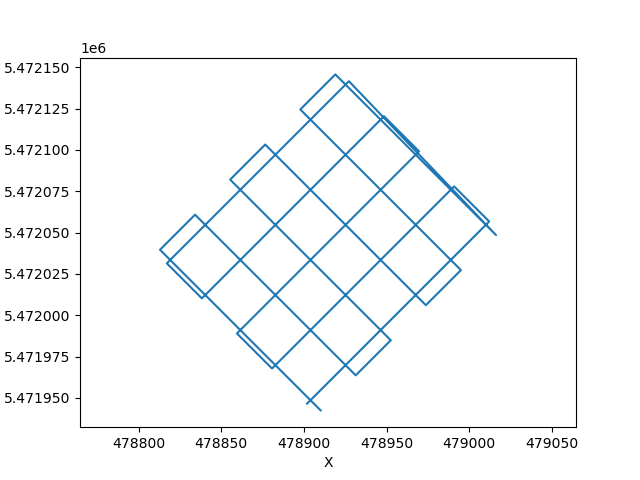

In [24]:
plot = flight_planner.plot_flight_plan(wp)

Now, we'll set the flying speed and the altitude.

In [25]:
speed = 5.0
altitude = 465  # important: Absolute height, not height above ground!

And export the legs for the survey XML-file.

In [26]:
legs = flight_planner.write_legs(wp, altitude=altitude, template_id="uls_template", speed=speed)

We can now write our survey file:

In [27]:
survey_content = """<?xml version="1.0" encoding="UTF-8"?>
<document>
	<scannerSettings id="uls_template" active="true" scanAngle_deg="90" pulseFreq_hz="100000" scanFreq_hz="50" />
	<survey name="Arboretum" platform="data/platforms.xml#copter_linearpath" scanner="data/scanners_als.xml#riegl_vux-1uav" scene="{}#{}">
    {}
	</survey>
</document>

""".format(scene_file, scene_id, legs)

We define the default scanner settings in the first tag (`<scannerSettings ...>`). In the `<survey ...>` tag, we provide the scanner, platform, and scene that the survey should use. Then we need to write the individual legs between the opening and the closing survey tags to define the scanner location, movement and speed. An overview of all possible parameters is given on the [survey page in our Wiki](https://github.com/3dgeo-heidelberg/helios/wiki/Survey). 

We can now write our survey to the file:

In [28]:
with open(survey_file, "w") as f:
    f.write(survey_content)

Now we are ready to go. We can execute the survey from this notebook using the helios python bindings that we imported in the beginning of the notebook. 
A small introduction on using the python bindings can be found here:
* [Python bindings: Getting started](https://github.com/3dgeo-heidelberg/helios/wiki/Python-bindings-%F0%9F%90%8D-Getting-started)
* [Python bindings: Scene manipulation](https://github.com/3dgeo-heidelberg/helios/wiki/Python-bindings-%F0%9F%90%8D-Scene-manipulation)

Configure simulation context and build a simulation:

In [29]:
# Sim context.
# Set logging.
pyhelios.loggingQuiet()
# Set seed for random number generator.
pyhelios.setDefaultRandomnessGeneratorSeed("123")

In [30]:
# use SimulationBuilder to configure simulation
simB = SimulationBuilder(str(survey_file), "assets/", "output/")
simB.setLasOutput(True)
simB.setZipOutput(True)
simB.setSimFrequency(10000)

Now, we can build the simulation and load the survey. Loading the survey will take a while, so please be patient.

In [31]:
# build the simulation 
sim = simB.build()

SimulationBuilder is building simulation ...
SimulationBuilder built simulation in 618.3611608 seconds


In [32]:
# Start the simulation.
start_time = time.time()
sim.start()

if sim.isStarted():
    print('Simulation has started!\nSurvey Name: {survey_name}\n{scanner_info}'.format(
        survey_name = sim.sim.getSurvey().name,
        scanner_info = sim.sim.getScanner().toString()))

Simulation has started!
Survey Name: Arboretum
Scanner: riegl_vux-1uav Power: 4.000000 W Divergence: 0.500000 mrad Wavelength: 1064 nm Visibility: 23.000000 km


In [33]:
while sim.isRunning():
    duration = time.time()-start_time
    mins = duration // 60
    secs = duration % 60
    print("\r"+"Simulation is running since {} min and {} sec. Please wait.".format(int(mins), int(secs)), end="")
    time.sleep(10)

if sim.isFinished():
    print("\n"+"Simulation has finished!")

Simulation is running since 1 min and 10 sec. Please wait.
Simulation has finished!


Once the simulation is finished, we can process the outputs.

In [34]:
# Create instance of PyHeliosOutputWrapper class using sim.join(). 
# Contains attributes 'measurements' and 'trajectories' which are Python wrappers of classes that contain the output vectors.
output = sim.join()

# Create instances of vector classes by accessing 'measurements' and 'trajectories' attributes of output wrapper.
measurements = output.measurements
trajectories = output.trajectories

# Get amount of points in trajectory and amount of measurements by accessing length of measurement and trajectory vectors.
print('Number of measurements : {n}'.format(n=len(measurements)))
print('Number of points in trajectory : {n}'.format(n=len(trajectories)))

Number of measurements : 10646112
Number of points in trajectory : 6415


The simulation outputs can be found in `helios\output\Survey Playback\Arboretum\YYYY-MM-DD_HH-MM-SS\points`. For each run a folder will be created in the "Arboretum"-folder named by the timestamp of execution. There is one point cloud and trajecotry file for each flight strip.

## Plot the point cloud and trajectory

`pyhelios` has a function `outputToNumpy` which returns both measurement and trajectory output of HELIOS++ as numpy arrays. We use this function below and then plot our point clouds with `matplotlib`.

In [35]:
# Output is two np.arrays. One for measurements and one for trajectory points.
measurement_points, trajectory_points = outputToNumpy(output)

We saw earlier, that we simulated millions of points. Let's subsample them for plotting and show only every 50th point. 

In [36]:
# Points to be plotted
# First three cols are x, y and z vals
traj_points=trajectory_points[:,:3]
points = measurement_points[::50,:3]

In [37]:
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

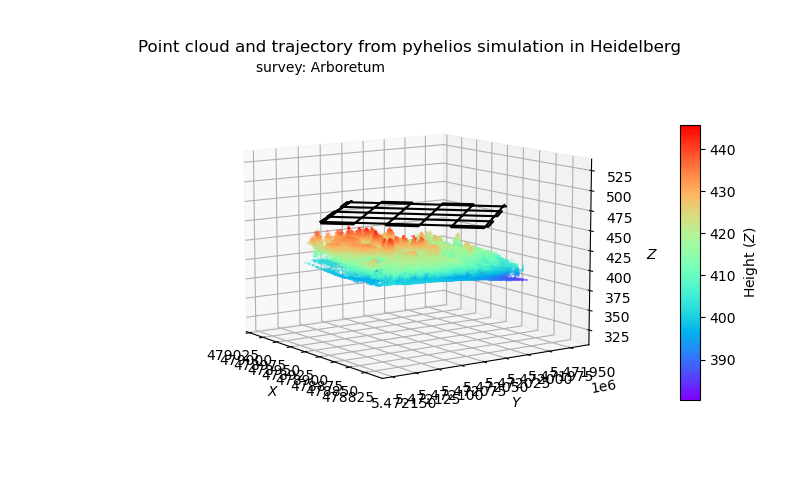

In [38]:
# Matplotlib figure.
fig = plt.figure(figsize=(8,5))
# Axes3d axis onto mpl figure.
ax = fig.add_subplot(projection='3d')

# Scatter plot of points (coloured by height).
sc = ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=points[:, 2], cmap="rainbow", s=0.02, label='scene')
# Plot of trajectory.
ax.plot(traj_points[:,0], traj_points[:,1], traj_points[:,2], c = 'black', label = 'scanner trajectory')
cax = plt.axes([0.85, 0.2, 0.025, 0.55])
cbar = plt.colorbar(sc, cax=cax)
cbar.set_label("Height ($Z$)")

# Add axis labels.
ax.set_xlabel('$X$')
ax.set_ylabel('$Y$')
ax.set_zlabel('$Z$')

set_axes_equal(ax)

# Set title.
ax.set_title(label='Point cloud and trajectory from pyhelios simulation in Heidelberg')
# Set subtitle.
ax.text2D(0.1, 0.97, "survey: {s}".format(s=sim.sim.getSurvey().name, n=len(trajectories)),
                                                                              fontsize='10', transform=ax.transAxes)
ax.view_init(elev=10, azim=145)

# Display results
plt.show()

Let's extract a section of the original and the simulated point cloud...

In [39]:
xmin, ymin, xmax, ymax = [478894.3, 5472000.0, 478899.3, 5472100.0]

section_sim = measurement_points[(measurement_points[:, 0] > xmin) & 
                                 (measurement_points[:, 0] < xmax) & 
                                 (measurement_points[:, 1] > ymin) & 
                                 (measurement_points[:, 1] < ymax)]
import laspy
with laspy.open(data_uls) as f:
    las = f.read()

    arr = np.vstack((las.x, las.y, las.z)).transpose()
    section_or = arr[(arr[:, 0] > xmin) & 
                     (arr[:, 0] < xmax) & 
                     (arr[:, 1] > ymin) & 
                     (arr[:, 1] < ymax)]

... and plot this:

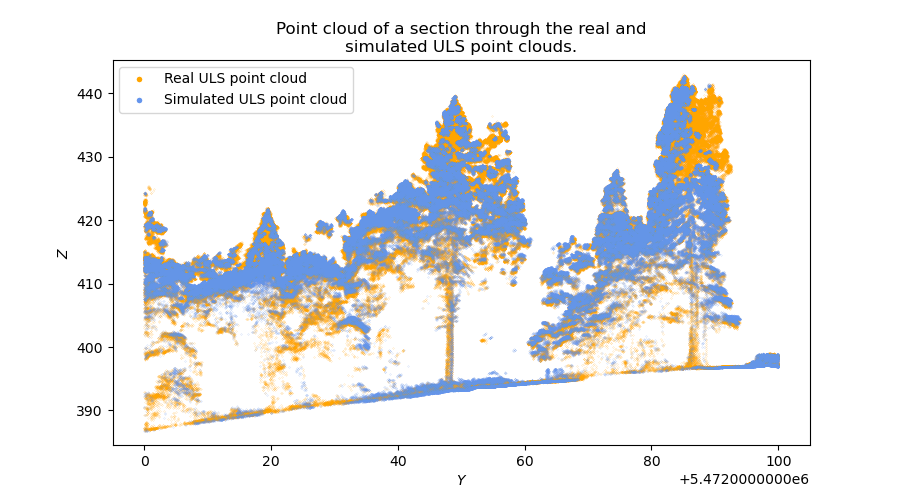

In [40]:
# Matplotlib figure.
fig = plt.figure(figsize=(9,5))
# Axes3d axis onto mpl figure.
ax = fig.add_subplot()

# Scatter plot of original and simulated points in different colors
ax.scatter(section_or[:, 1], section_or[:, 2], c="orange", s=0.01)
ax.scatter(section_sim[:, 1], section_sim[:, 2], c="cornflowerblue", s=0.01)

# Add axis labels.
ax.set_xlabel('$Y$')
ax.set_ylabel('$Z$')
ax.axis('equal')

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Real ULS point cloud',
                          markerfacecolor='orange', markersize=5),
          Line2D([0], [0], marker='o', color='w', label='Simulated ULS point cloud',
                          markerfacecolor='cornflowerblue', markersize=5)]
plt.legend(handles=legend_elements)

# Set title.
from textwrap import wrap
title = ax.set_title("\n".join(wrap("Point cloud of a section through the real and simulated ULS point clouds.", 50)))

plt.show()

Execute the following code to load the point cloud simulated using a voxel size of 0.1 m, e.g., if you were not able to simulate with such a small voxel size on your machine (click the box and change from "Raw NBConvert" to "Code" or simply press `esc` and then `y`).

Let's create another plot where we can see the point clouds side by side.

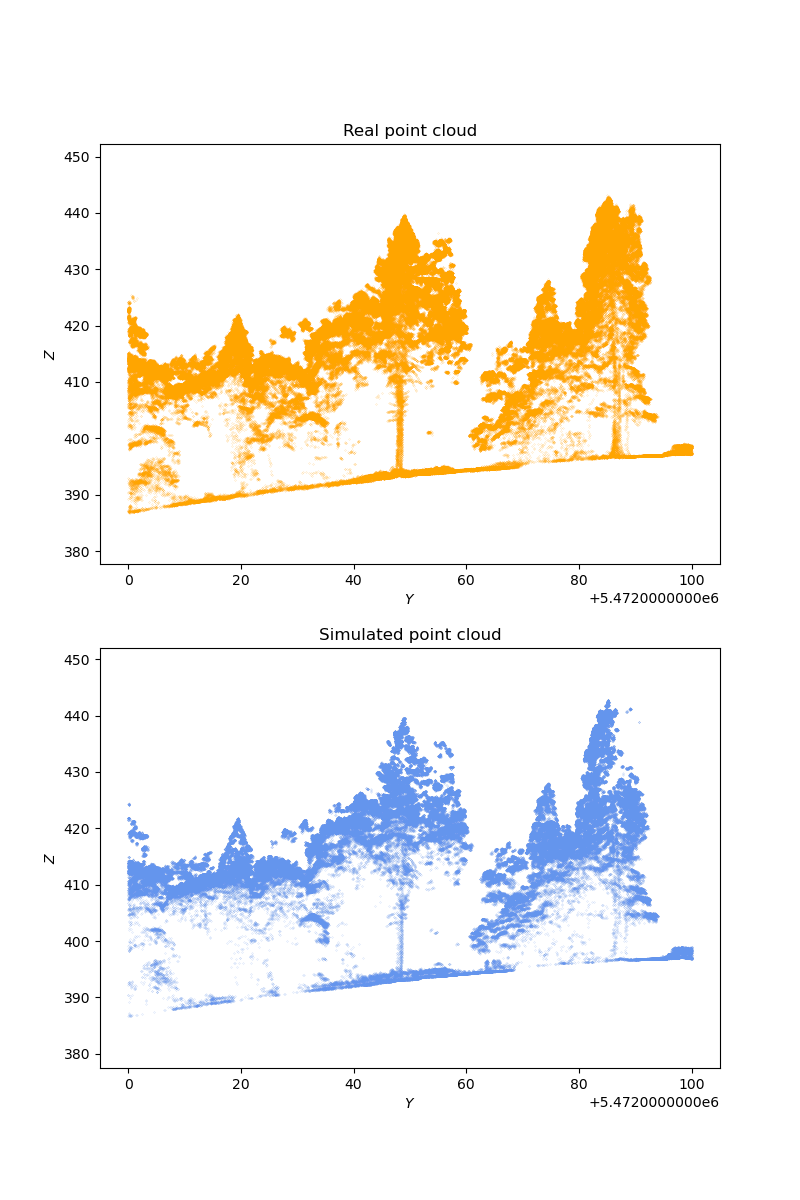

In [41]:
fig, axs = plt.subplots(2, 1, figsize=(8,12))
axs[0].scatter(section_or[:, 1], section_or[:, 2], color="orange", s=0.01)
axs[0].set_title("Real point cloud")
axs[0].set_xlabel('$Y$')
axs[0].set_ylabel('$Z$')
axs[0].axis("equal")
#plt.subplot(212)
axs[1].scatter(section_sim[:, 1], section_sim[:, 2], color="cornflowerblue", s=0.01)
axs[1].set_title("Simulated point cloud")
axs[1].set_xlabel('$Y$')
axs[1].set_ylabel('$Z$')
axs[1].axis("equal")
fig.subplots_adjust(hspace=0.2)
plt.show()

We can see some differences in the simulated point clouds, especially the upper canopy. In the input TLS point clouds, there are occluded areas and areas with low point density in the upper canopy. This will result in an "incomplete" or sparse voxel model of some tree crowns, which of course propagates into the simulated point cloud.